## Library imports

In [1]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

import random
from osgeo import gdal
from pathlib import Path
import io
from scipy.sparse import csr_matrix
from scipy.sparse import load_npz

import zipfile
from collections import defaultdict

import re
from tqdm import tqdm
import shutil
import calendar

import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.transform import Affine
from rasterio.merge import merge

import joblib
import math
import cv2
from scipy import sparse
import traceback

import pyproj
from pyproj import Proj

from shapely.ops import transform
from shapely.geometry import Polygon

import multiprocessing
from multiprocessing.pool import ThreadPool
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

import time
import random

In [2]:
import statsmodels.api as sm

# Define paths

In [3]:
base_dir = '/scratch/user/anshulya/hls/github/hls/'

# GIS

In [4]:
s2_tiles = gp.read_file(os.path.join(base_dir, 'data/auxiliary/gis/s2-tiles.geojson'))
conus = gp.read_file(os.path.join(base_dir, 'data/auxiliary/gis/s_05mr24/s_05mr24.shp'))
s2_res = pd.read_csv(os.path.join(base_dir, 'data/auxiliary/gis/sentinel_tiles.csv'))
grand = gp.read_file(os.path.join(base_dir, 'data/auxiliary/gis/hls_reservoirs.geojson'))

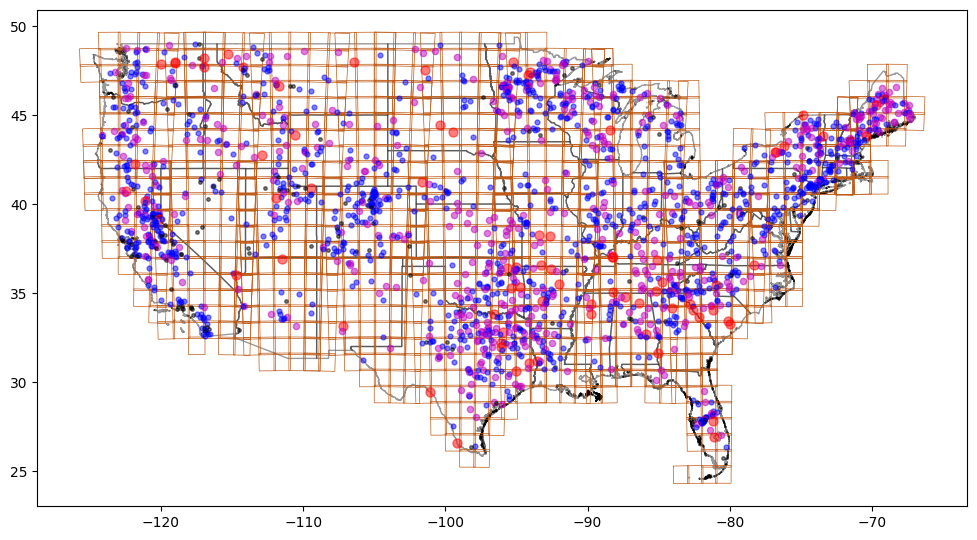

In [5]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
conus.plot(ax = ax, facecolor='none', ec = 'k',alpha=0.4)
s2_tiles.plot(ax = ax, facecolor='none', ec = '#bf5b17', linewidth=0.5)

for gid in grand['GRAND_ID']:
    x = grand.loc[grand['GRAND_ID']==gid, 'LONG_DD']
    y = grand.loc[grand['GRAND_ID']==gid, 'LAT_DD']
    s = grand.loc[grand['GRAND_ID']==gid, 'AREA_SKM'].values[0]
    if s<1:
        ax.plot(x, y, 'k.-', markersize=5, alpha=0.5)
    elif s<10:     
        ax.plot(x, y, 'b.-', markersize=7, alpha=0.5)
    elif s<100:
        ax.plot(x, y, 'm.-', markersize=9, alpha=0.5)
    else:
        ax.plot(x, y, 'r.-', markersize=13, alpha=0.5)
plt.show()

# Data Pre-processing for a single reservoir

In [6]:
grand_id = 657 # GRanD v1.3 ID for the reservoir you are interested in

In [7]:
for idx, row in grand[grand['GRAND_ID']==grand_id].iterrows():
    print('Reservoir Name: ', row['RES_NAME'])
    print('Dam Name: ', row['DAM_NAME'])
    print('River Name: ', row['RIVER'])
    print('Reservoir Area: ', row['AREA_SKM'], ' sq. km')
    print('Reservoir Location: ', row['LAT_DD'], row['LONG_DD'])

Reservoir Name:  Elephant Butte Reservoir
Dam Name:  Elephant Butte Dike
River Name:  Rio Grande
Reservoir Area:  110.37  sq. km
Reservoir Location:  33.156049 -107.189253


In [8]:
down_tiles = s2_res[s2_res['GRAND_ID']==grand_id]['Name'].values # tiles to download
print(down_tiles)

['13SBS' '13SBT' '13SCS' '13SCT']


## Steps to download the tiles:

### Step 1:
- Update the tile names in ~/code/bulk_download/tiles/tile_id.txt with each tile name separated by a space. eg: '13SBS 13SBT 13SCS 13SCT'

In [15]:
# write tiles separated by a space to the text file
with open(os.path.join(base_dir,'code/bulk_download/tiles/tile_id.txt'), 'w') as f:
    f.write(' '.join(down_tiles))

# Read back the contents
with open(os.path.join(base_dir,'code/bulk_download/tiles/tile_id.txt'), 'r') as f:
    contents = f.read()
    print("File contents:", contents)

File contents: 13SBS 13SBT 13SCS 13SCT


### Steps 2-3:
- Edit the job file named 'hls_bulk.sh' on your HPC environment.
- Populate the last line of the job file with your specific paths: bash ~/code/bulk_download/getHLS.sh ~/bulk_download/tiles/tile_id.txt <start-date> <end-date> <data-download-directory>. eg: bash ~/code/bulk_download/getHLS.sh ~/bulk_download/tiles/tile_id.txt 2016-01-01 2023-12-31 ~/data/raw_tiles/

In [114]:
# HPC parameters
job_name = f'bulk_tile_download_{grand_id}'
job_run_time = '10:00:00'
num_nodes = '1'
ntasks_per_node = '8'
memory = '8G'
log_file_path = str(os.path.join(base_dir, f'jobs/log_files/{job_name}.%j'))

#filepaths
script_path = str(os.path.join(base_dir, 'code/bulk_download/getHLS.sh'))
tile_id_txt_filepath = str(os.path.join(base_dir, 'code/bulk_download/tiles/tile_id.txt'))
start_date = '2016-01-01' #YYYY-MM-DD format
end_date = '2022-12-31'
data_dir = str(os.path.join(base_dir, 'data'))

In [115]:
script_content = f"""#!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name={job_name}      #Set the job name to "JobExample1"
#SBATCH --time={job_run_time}               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes={num_nodes}                    #Request 1 node
#SBATCH --ntasks-per-node={ntasks_per_node}        #Request 8 tasks/cores per node
#SBATCH --mem={memory}                     #Request 8GB per node 
#SBATCH --output={log_file_path}      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"
module load WebProxy
pip install geopandas
pip install rasterio

bash {script_path} {tile_id_txt_filepath} {start_date} {end_date} {data_dir}
"""

print(script_content)

#!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name=bulk_tile_download_657      #Set the job name to "JobExample1"
#SBATCH --time=10:00:00               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes=1                    #Request 1 node
#SBATCH --ntasks-per-node=8        #Request 8 tasks/cores per node
#SBATCH --mem=8G                     #Request 8GB per node 
#SBATCH --output=/scratch/user/anshulya/hls/github/hls/jobs/log_files/bulk_tile_download_657.%j      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"
module load WebProxy
pip install geopandas
pip install rasterio

bash /scratch/user/anshulya/hls/github/hls/code/bulk_download/getHLS.sh /scratch/user/anshulya/hls/github/hls/code/bulk_download/tiles/tile_id.txt 2016-01-01 2022-12-31 /scratch/user/anshulya/hls/github/hls/data



In [116]:
with open(os.path.join(base_dir,'jobs/hls_bulk.sh'), 'w') as f:
    f.write(script_content)

# Read back the contents
with open(os.path.join(base_dir,'jobs/hls_bulk.sh'), 'r') as f:
    contents = f.read()
    print("Tile download HPC script contents:\n", contents)

Tile download HPC script contents:
 #!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name=bulk_tile_download_657      #Set the job name to "JobExample1"
#SBATCH --time=10:00:00               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes=1                    #Request 1 node
#SBATCH --ntasks-per-node=8        #Request 8 tasks/cores per node
#SBATCH --mem=8G                     #Request 8GB per node 
#SBATCH --output=/scratch/user/anshulya/hls/github/hls/jobs/log_files/bulk_tile_download_657.%j      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"
module load WebProxy
pip install geopandas
pip install rasterio

bash /scratch/user/anshulya/hls/github/hls/code/bulk_download/getHLS.sh /scratch/user/anshulya/hls/github/hls/code/bulk_download/tiles/tile_id.txt 2016-01-01 2022-12-31 /scratch/user/anshulya/hls/github/

### Step 4:
- Run the script to download the tiles

In [117]:
import subprocess

script_path = os.path.join(base_dir, "jobs/hls_bulk.sh")

# Run the sbatch command
result = subprocess.run(["sbatch", script_path], capture_output=True, text=True)

# Print the output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 Submitted batch job 2375557

STDERR:
 


In [163]:
# Run this command to capture the status of the download script
result = subprocess.run(['squeue', '-u', 'anshulya'], capture_output=True, text=True)

# Print output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 JOBID        NAME                 USER                     PARTITION              NODES  CPUS  STATE        TIME         TIME_LEFT    START_TIME        REASON                   NODELIST
2374517      sys/dashboard/sys/ju anshulya                 cpu                    1      12    RUNNING      4:36:25      7:23:35      2025-05-19T12:47  None                     fc018

STDERR:
 


### Step 5:
- Edit the script rearrange_tiles_script.sh with your tile list and then run the script. This script rearranges the native folder structure of tiles into a folder structure easier to process with our classification code.

In [164]:
# HPC parameters
job_name = f'rearrange_tiles_{grand_id}'
job_run_time = '10:00:00'
num_nodes = '1'
ntasks_per_node = '48'
memory = '16G'
log_file_path = str(os.path.join(base_dir, f'jobs/log_files/{job_name}.%j'))

#filepaths
script_path = str(os.path.join(base_dir, 'code/rearrange_tiles.py'))
tiles = ' '.join(down_tiles)

In [165]:
script_content = f"""#!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name={job_name}      #Set the job name to "JobExample1"
#SBATCH --time={job_run_time}               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes={num_nodes}                    #Request 1 node
#SBATCH --ntasks-per-node={ntasks_per_node}        #Request 8 tasks/cores per node
#SBATCH --mem={memory}                     #Request 8GB per node 
#SBATCH --output={log_file_path}      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"

python {script_path} --tiles {tiles} --path {base_dir}"""

print(script_content)

#!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name=rearrange_tiles_657      #Set the job name to "JobExample1"
#SBATCH --time=10:00:00               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes=1                    #Request 1 node
#SBATCH --ntasks-per-node=48        #Request 8 tasks/cores per node
#SBATCH --mem=16G                     #Request 8GB per node 
#SBATCH --output=/scratch/user/anshulya/hls/github/hls/jobs/log_files/rearrange_tiles_657.%j      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"

python /scratch/user/anshulya/hls/github/hls/code/rearrange_tiles.py --tiles 13SBS 13SBT 13SCS 13SCT --path /scratch/user/anshulya/hls/github/hls/


In [166]:
with open(os.path.join(base_dir,'jobs/rearrange_tiles_script.sh'), 'w') as f:
    f.write(script_content)

# Read back the contents
with open(os.path.join(base_dir,'jobs/rearrange_tiles_script.sh'), 'r') as f:
    contents = f.read()
    print("Reaarange tiles HPC script contents:\n", contents)

Reaarange tiles HPC script contents:
 #!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name=rearrange_tiles_657      #Set the job name to "JobExample1"
#SBATCH --time=10:00:00               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes=1                    #Request 1 node
#SBATCH --ntasks-per-node=48        #Request 8 tasks/cores per node
#SBATCH --mem=16G                     #Request 8GB per node 
#SBATCH --output=/scratch/user/anshulya/hls/github/hls/jobs/log_files/rearrange_tiles_657.%j      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"

python /scratch/user/anshulya/hls/github/hls/code/rearrange_tiles.py --tiles 13SBS 13SBT 13SCS 13SCT --path /scratch/user/anshulya/hls/github/hls/


In [167]:
script_path = os.path.join(base_dir, "jobs/rearrange_tiles_script.sh")

# Run the sbatch command
result = subprocess.run(["sbatch", script_path], capture_output=True, text=True)

# Print the output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 Submitted batch job 2376219

STDERR:
 


In [168]:
# Run this command to capture the status of the download script
result = subprocess.run(['squeue', '-u', 'anshulya'], capture_output=True, text=True)

# Print output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 JOBID        NAME                 USER                     PARTITION              NODES  CPUS  STATE        TIME         TIME_LEFT    START_TIME        REASON                   NODELIST
2376219      rearrange_tiles_657  anshulya                 cpu                    1      48    PENDING      0:00         10:00:00     N/A               None                     
2374517      sys/dashboard/sys/ju anshulya                 cpu                    1      12    RUNNING      4:36:39      7:23:21      2025-05-19T12:47  None                     fc018

STDERR:
 


### Step 6:
- Your downloaded tiles will be available in ~/data/cluster/

In [9]:
print(os.listdir(os.path.join(base_dir, 'data/cluster')))

['13SCS', '13SBS', '13SCT', '13SBT']


## Check Tile-Reservoir overlap

In [10]:
current_tiles = down_tiles.copy() # update the names of the tiles here

The downloaded tiles might have extra reservoirs which you might/might not be interested in processing. In this section of the code we visualize the location of these reservoirs and make an informed decision of whether we want to process them or not.

In [11]:
res_list = [x for x in s2_res.loc[s2_res['Name'].isin(current_tiles),'GRAND_ID'].unique()]
print(res_list) # these are the reservoirs that either fully or partially lie in the current tiles

[657, 664]


In [12]:
# current_todo = [657] # you can update this variable with the reservoir you are interested in
current_todo = res_list # if you are interested in all the reservoirs in your downloaded tiles

In [13]:
todo_res_list = {}
ext_res = []
print('Reservoirs only partially overlapping with the current tiles: ')
print('--------------------------------------')
for r in current_todo:
    tiles = s2_res.loc[s2_res['GRAND_ID']==r,'Name'].unique()
    rogue = [t for t in tiles if t not in current_tiles]
    
    if len(rogue)>0:
        # print(r, tiles)
        print(r, ', Other tiles required for this reservoir: ', [t for t in tiles if t not in current_tiles])
        ext_res.append(r)
    else:
        # d_tiles = [t for t in tiles if t in todo_tiles]
        todo_res_list[r] = list(tiles)
print('Reservoirs that can be processed: ',len(todo_res_list),'; Partial reservoirs: ', len(ext_res))

Reservoirs only partially overlapping with the current tiles: 
--------------------------------------
Reservoirs that can be processed:  2 ; Partial reservoirs:  0


### Handling Partial Reservoirs
Although we only want to process reservoirs that lie entirely inside the currently downloaded tiles, we might still be interested in reservoirs which partially overlap. Hence, plotting all the partial reservoirs along with the current tiles gives us a better idea

In [57]:
for r in ext_res:
    tiles = s2_res.loc[s2_res['GRAND_ID']==r,'Name'].unique()
    d_tiles = [t for t in tiles if t in current_tiles]

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    s2_tiles[s2_tiles['Name'].isin(tiles)].plot(ax = ax[0], facecolor='None', ec = 'r', linewidth=0.5)
    grand[grand['GRAND_ID'].isin([r])].plot(ax = ax[0], facecolor='blue', ec = 'k', linewidth=0.5)
    
    for _, row in s2_tiles[(s2_tiles['Name'].isin(tiles))].iterrows():
        centroid = row['geometry'].centroid
        ax[0].text(centroid.x, centroid.y, row['Name'], fontsize=12, ha='center', va='center', color='black')
    
    s2_tiles[s2_tiles['Name'].isin(d_tiles)].plot(ax = ax[1], facecolor='None', ec = 'r', linewidth=0.5)
    grand[grand['GRAND_ID'].isin([r])].plot(ax = ax[1], facecolor='blue', ec = 'k', linewidth=0.5)

    for _, row in s2_tiles[(s2_tiles['Name'].isin(d_tiles))].iterrows():
        centroid = row['geometry'].centroid
        ax[1].text(centroid.x, centroid.y, row['Name'], fontsize=12, ha='center', va='center', color='black')

    plt.title(r)
    plt.tight_layout()
    plt.show()    

* Current tiles (shown on the right) overlap the entire reservoir, hence we may go ahead with processing this reservoir as well

In [58]:
okay_rogue = [] # Add the partially covered reservoirs here if you want to include them in your processing as well

In [59]:
todo_res_list = {}
ext_res = []
for r in current_todo:
    tiles = s2_res.loc[s2_res['GRAND_ID']==r,'Name'].unique()
    rogue = [t for t in tiles if t not in current_tiles]
    if len(rogue)>0:
        if r in okay_rogue:
            d_tiles = [t for t in tiles if t in current_tiles]
            todo_res_list[r] = list(d_tiles)
        else:
            print(r, [t for t in tiles if t not in current_tiles])
            ext_res.append(r)
    else:
        todo_res_list[r] = list(tiles)
print('Reservoirs to be processed: ',len(todo_res_list),'; Reservoirs not processed: ', len(ext_res))

Reservoirs to be processed:  2 ; Reservoirs not processed:  0


### Maximum extent rasters
Find out the maximum extent rasters of the reservoirs (important for rasters with partial reservoir coverage and cloud correction)

In [14]:
todo_res_gid = todo_res_list.keys()
print(len(todo_res_gid))

2


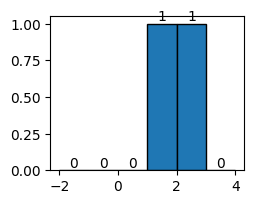

In [15]:
data = np.log10(grand.loc[grand['GRAND_ID'].isin(todo_res_gid), 'AREA_SKM'].values)

# Define bin edges: <1, 1, 10, 100, 1000 km2 (log10 values: -inf, 0, 1, 2, 3)
bins = [-2, -1, 0, 1, 2, 3, 4]

plt.figure(figsize=(2.5,2))

# Plot histogram
counts, edges, patches = plt.hist(data, bins=bins, edgecolor='black')

# Add count labels above each bar
for count, edge in zip(counts, edges[:-1]):
    plt.text(edge + (edges[1] - edges[0]) / 2, count, int(count), ha='center', va='bottom')

# Add labels and show plot
plt.show()

In [16]:
max_date_df = pd.DataFrame(columns=['res_gid', 'l30_date', 's30_date'])
single_tile = 0
for r in tqdm(todo_res_gid):
    try:
        sflag = 0
        lflag = 0
        
        tiles = todo_res_list[r]
        if len(tiles)>1:
            dates = os.listdir(os.path.join(base_dir, f'data/cluster/{tiles[0]}/unmerged_rasters'))
            for t in tiles[1:]:
                dates_ = os.listdir(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters'))
                dates = [d for d in dates if d in dates_]
                if len(dates) == 0:
                    print('No full date for ', r)
                    break
            if len(dates)>0:
                # print('Full dates for ',r, ': ', dates)
                for d in dates:
                    s30 = 0
                    l30 = 0
                    for t in tiles:
                        if 'S30' in os.listdir(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{d}')):
                            s30 = s30 + 1
                        if 'L30' in os.listdir(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{d}')):
                            l30 = l30 + 1
                    if s30 == len(tiles):
                        x = np.sum([len(os.listdir(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{d}/S30'))) for t in tiles])
                        if x == 16*len(tiles):
                            sdate = d
                            sflag = 1
                    if l30 == len(tiles):
                        x = np.sum([len(os.listdir(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{d}/L30'))) for t in tiles])
                        if x == 12*len(tiles):
                            ldate = d
                            lflag = 1
                    if sflag ==1 and lflag == 1:
                        new_row = pd.DataFrame([{'res_gid': r, 'l30_date': ldate, 's30_date': sdate}])
                        max_date_df = pd.concat([max_date_df, new_row], ignore_index=True)
                        break
        else:
            single_tile = single_tile + 1
            dates = os.listdir(os.path.join(base_dir, f'data/cluster/{tiles[0]}/unmerged_rasters'))
            for d in dates:
                if 'S30' in os.listdir(os.path.join(base_dir, f'data/cluster/{tiles[0]}/unmerged_rasters/{d}')):
                    x = np.sum([len(os.listdir(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{d}/S30'))) for t in tiles])
                    if x == 16*len(tiles):
                        sdate = d
                        sflag = 1
                if 'L30' in os.listdir(os.path.join(base_dir, f'data/cluster/{tiles[0]}/unmerged_rasters/{d}')):
                    x = np.sum([len(os.listdir(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{d}/L30'))) for t in tiles])
                    if x == 12*len(tiles):
                        ldate = d
                        lflag = 1
                if sflag ==1 and lflag == 1:
                    new_row = pd.DataFrame([{'res_gid': r, 'l30_date': ldate, 's30_date': sdate}])
                    max_date_df = pd.concat([max_date_df, new_row], ignore_index=True)
                    break
    except:
        traceback.print_exc()
        continue

100%|██████████| 2/2 [00:00<00:00, 27.07it/s]


In [17]:
def project_hls_latlon(hls, jrc, filename = 'hls_proj.tif'):
    projTIF = filename
    transform, width, height = calculate_default_transform(
        hls.crs, jrc.crs, hls.width, hls.height, *hls.bounds)
    kwargs = hls.meta.copy()
    kwargs.update({
        'crs': jrc.crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rio.open(projTIF, 'w', **kwargs) as dst:
        for i in range(1, hls.count + 1):
            reproject(
                source=rio.band(hls, i),
                destination=rio.band(dst, i),
                src_transform=hls.transform,
                src_crs=hls.crs,
                dst_transform=transform,
                dst_crs=jrc.crs,
                resampling=Resampling.nearest)
    return projTIF

def reproject_unmerged_rasters(save_path):
    print('start of reprojections')
    for filename in tqdm(os.listdir(save_path)):
        if filename == 'tile_metadata.csv':
            continue
        if os.path.isfile(os.path.join(save_path, filename)):
            jrc = rio.open(os.path.join(base_dir, f'data/383_LAKE_MEAD.tif'))
            hls = rio.open(os.path.join(save_path, filename))
            project_hls_latlon(hls, jrc, os.path.join(save_path, filename))

## Merge downloaded rasters
def merge_max_rasters(res_gid, bands, l30_rasters_to_merge, save_path, sat):
    if not os.path.exists(os.path.join(save_path, sat)):
        os.makedirs(os.path.join(save_path, sat))
    
    for b in tqdm(bands):
        bandpaths = []
        for dirpath in l30_rasters_to_merge:
            bandpaths.append([os.path.join(dirpath, bname) for bname in os.listdir(dirpath) if b in bname][0])
        # print(bandpaths)
        rasters = [rio.open(raster_path) for raster_path in bandpaths]
    
        # Merge the rasters into a single dataset
        b1_merged, b1_merged_transform = merge(rasters)
    
        # Update the metadata of the merged dataset
        b1_merged_meta = rasters[0].meta.copy()
        b1_merged_meta.update({
            'height': b1_merged.shape[1],
            'width': b1_merged.shape[2],
            'transform': b1_merged_transform
        })
        
        if not os.path.exists(os.path.join(save_path, sat)):
            os.makedirs(os.path.join(save_path, sat))
        
        # Create a new raster file to store the stitched data
        output_path = os.path.join(save_path, sat, b +'_stitched_raster.tif')
        # print(output_path)
        with rio.open(output_path, 'w', **b1_merged_meta) as dst:
            dst.write(b1_merged)
        
        # Close all the input rasters
        for raster in rasters:
            raster.close()


def getFeatures(gdf):
  """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
  import json
  return [json.loads(gdf.to_json())['features'][0]['geometry']]

def clip_raster(src, res, fname = 'clipped_hls.tif'):
  coords = getFeatures(res)

  # Clip the raster with Polygon
  out_image, out_transform = mask(dataset=src, shapes=coords, crop=True, nodata=-9999)

  # Update the metadata with the new bounds and resolution
  out_meta = src.meta.copy()
  out_meta.update({
      'height': out_image.shape[1],
      'width': out_image.shape[2],
      'transform': out_transform
  })

  with rio.open(fname, 'w', **out_meta) as dest:
    dest.write(out_image)
  return fname

In [18]:
okay_max = []
for res_gid in todo_res_gid:
    flag1, flag2 = 0, 0
    if os.path.exists(os.path.join(base_dir, f'data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif')):
        print(f'Max Landsat raster already available for: {res_gid}')
        
        # ras = rio.open(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif')
        # fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        # show(ras, ax = ax)
        # grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        # plt.tight_layout()
        # plt.show()
        flag1 = 1
        
    if os.path.exists(os.path.join(base_dir, f'data/max_rasters/{res_gid}/S30/B05_clipped_raster.tif')):
        print(f'Max Sentinel raster already available for: {res_gid}')

        # ras = rio.open(f'/scratch/user/anshulya/hls/data/max_rasters/{res_gid}/S30/B8A_clipped_raster.tif')
        # fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        # show(ras, ax = ax)
        # grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        # plt.tight_layout()
        # plt.show()
        flag2 = 1

    if flag1 == 1 and flag2 ==1:
        okay_max.append(res_gid)

Max Landsat raster already available for: 657
Max Sentinel raster already available for: 657
Max Landsat raster already available for: 664
Max Sentinel raster already available for: 664


In [66]:
def process_res_gid(res_gid):
    if res_gid in okay_max:
        return
    
    s30_date = max_date_df.loc[max_date_df['res_gid'] == res_gid, 's30_date'].values[0]
    l30_date = max_date_df.loc[max_date_df['res_gid'] == res_gid, 'l30_date'].values[0]
    
    tiles = todo_res_list[res_gid]
    print(res_gid, tiles)
    
    s30_rasters_to_merge = [
        os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{s30_date}/S30') for t in tiles
    ]
    l30_rasters_to_merge = [
        os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{l30_date}/L30') for t in tiles
    ]

    print(len(s30_rasters_to_merge), len(l30_rasters_to_merge))
    
    # Define bands to be downloaded
    l30_bands = ['B01', 'B03', 'B05', 'B06', 'B04', 'Fmask', 'B07', 'B10', 'B02', 'B11', 'SAA', 'SZA']
    s30_bands = ['B10', 'B07', 'B09', 'B04', 'B03', 'B11', 'B06', 'B12', 'B02', 'B8A', 'B08', 'B01', 'Fmask', 'B05', 'SAA', 'SZA']

    save_path = os.path.join(base_dir, f'data/max_rasters/{res_gid}')
    res = grand.loc[grand['GRAND_ID'] == res_gid]
    res.geometry = res.geometry.buffer(0.01)
    
    # L30 merge
    for dirpath in l30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, l30_bands, l30_rasters_to_merge, save_path, 'L30')

    print('Clipping rasters ... ')
    for f in os.listdir(f'{save_path}/L30/'):
        ras = rio.open(f'{save_path}/L30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/L30/{cr_name}')
        ras.close()
        os.remove(f'{save_path}/L30/{f}')
    print('----------------------')

    # S30 merge
    for dirpath in s30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, s30_bands, s30_rasters_to_merge, save_path, 'S30')

    print('Clipping rasters ... ')
    for f in os.listdir(f'{save_path}/S30/'):
        ras = rio.open(f'{save_path}/S30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/S30/{cr_name}')
        ras.close()
        os.remove(f'{save_path}/S30/{f}')
    print('----------------------')

In [67]:
for idx, res_gid in enumerate(todo_res_list.keys()):

    print(idx)
    if res_gid in okay_max:
        continue
    
    s30_date = max_date_df.loc[max_date_df['res_gid']==res_gid,'s30_date'].values[0]
    l30_date = max_date_df.loc[max_date_df['res_gid']==res_gid,'l30_date'].values[0]
    
    tiles = todo_res_list[res_gid]
    print(res_gid, tiles)
    
    s30_rasters_to_merge = []
    l30_rasters_to_merge = []
    
    for t in tiles:
        s30_rasters_to_merge.append(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{s30_date}/S30'))
        l30_rasters_to_merge.append(os.path.join(base_dir, f'data/cluster/{t}/unmerged_rasters/{l30_date}/L30'))

    print(len(s30_rasters_to_merge),len(l30_rasters_to_merge))
    
    # Define bands to be downloaded
    l30_bands = ['B01', 'B03', 'B05', 'B06', 'B04', 'Fmask', 'B07',
            'B10', 'B02', 'B11','SAA','SZA']
    s30_bands = ['B10', 'B07', 'B09', 'B04', 'B03', 'B11', 'B06',
            'B12','B02', 'B8A', 'B08', 'B01', 'Fmask','B05','SAA','SZA']

    save_path = os.path.join(base_dir, f'data/max_rasters/{res_gid}')
    res = grand.loc[grand['GRAND_ID']==res_gid]
    res.geometry = res.geometry.buffer(0.01)
    
    #L30 merge
    for dirpath in l30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, l30_bands, l30_rasters_to_merge, save_path, 'L30')

    print('Clipping rasters ... ')
    for f in tqdm(os.listdir(f'{save_path}/L30/')):
        ras = rio.open(f'{save_path}/L30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/L30/{cr_name}' )
        ras.close()
        os.remove(f'{save_path}/L30/{f}')
    print('----------------------')

    #S30 merge
    for dirpath in s30_rasters_to_merge:
        reproject_unmerged_rasters(dirpath)
    print('Merging rasters ... ')
    merge_max_rasters(res_gid, s30_bands, s30_rasters_to_merge, save_path, 'S30')

    print('Clipping rasters ... ')
    for f in tqdm(os.listdir(f'{save_path}/S30/')):
        ras = rio.open(f'{save_path}/S30/{f}')
        cr_name = f.split('_')[0] + '_clipped_raster.tif'
        clip_raster(ras, res, f'{save_path}/S30/{cr_name}' )
        ras.close()
        os.remove(f'{save_path}/S30/{f}')
    print('----------------------')
    

0
657 ['13SBS', '13SBT', '13SCS', '13SCT']
4 4


/tmp/job.2364021/ipykernel_3139788/2594423947.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  res.geometry = res.geometry.buffer(0.01)
/home/anshulya/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


start of reprojections


100%|██████████| 12/12 [00:26<00:00,  2.19s/it]


start of reprojections


100%|██████████| 12/12 [00:08<00:00,  1.41it/s]


start of reprojections


100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


start of reprojections


100%|██████████| 12/12 [00:06<00:00,  1.92it/s]


Merging rasters ... 


100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Clipping rasters ... 


100%|██████████| 12/12 [00:01<00:00,  8.84it/s]


----------------------
start of reprojections


100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


start of reprojections


100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


start of reprojections


100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


start of reprojections


100%|██████████| 16/16 [00:11<00:00,  1.37it/s]


Merging rasters ... 


100%|██████████| 16/16 [00:16<00:00,  1.02s/it]


Clipping rasters ... 


100%|██████████| 16/16 [00:01<00:00, 15.04it/s]
/tmp/job.2364021/ipykernel_3139788/2594423947.py:30: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  res.geometry = res.geometry.buffer(0.01)
/home/anshulya/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


----------------------
1
664 ['13SBS']
1 1
start of reprojections


100%|██████████| 12/12 [00:06<00:00,  1.93it/s]


Merging rasters ... 


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Clipping rasters ... 


100%|██████████| 12/12 [00:00<00:00, 39.20it/s]


----------------------
start of reprojections


100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


Merging rasters ... 


100%|██████████| 16/16 [00:04<00:00,  3.89it/s]


Clipping rasters ... 


100%|██████████| 16/16 [00:00<00:00, 33.55it/s]

----------------------


In [68]:
for res_gid in todo_res_gid:
    if not (os.path.exists(os.path.join(base_dir, f'data/max_rasters/{res_gid}/L30/B01_clipped_raster.tif')) 
            and os.path.exists(os.path.join(base_dir, f'data/max_rasters/{res_gid}/S30/B01_clipped_raster.tif'))):
        print('Max raster does not exist for reservoir: ', res_gid)

Max Landsat raster already available for: 657


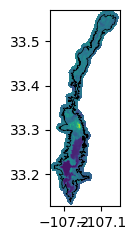

Max Sentinel raster already available for: 657


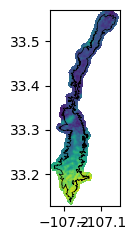

Max Landsat raster already available for: 664


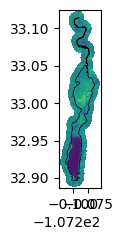

Max Sentinel raster already available for: 664


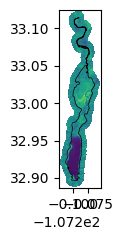

In [19]:
for res_gid in todo_res_gid:
    if os.path.exists(os.path.join(base_dir, f'data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif')):
        print(f'Max Landsat raster already available for: {res_gid}')
        
        ras = rio.open(os.path.join(base_dir, f'data/max_rasters/{res_gid}/L30/B05_clipped_raster.tif'))
        fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        show(ras, ax = ax)
        grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        plt.tight_layout()
        plt.show()
        
    if os.path.exists(os.path.join(base_dir, f'data/max_rasters/{res_gid}/S30/B05_clipped_raster.tif')):
        print(f'Max Sentinel raster already available for: {res_gid}')

        ras = rio.open(os.path.join(base_dir, f'data/max_rasters/{res_gid}/S30/B8A_clipped_raster.tif'))
        fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
        show(ras, ax = ax)
        grand[grand['GRAND_ID'].isin([res_gid])].plot(ax = ax, facecolor='none', ec = 'k', linewidth=0.5)
        plt.tight_layout()
        plt.show()

# Classification

In [20]:
import json

In [21]:
# This dictionary describes the reservoirs to be processed along with the data tiles required to process those reservoirs
print(todo_res_list) 
todo_res_list = {int(k): v for k, v in todo_res_list.items()}
print('---------------------------------------')

todo_tiles = list(set().union(*todo_res_list.values()))
print('Final list of tiles which will be used:')
print(todo_tiles)

{657: ['13SBS', '13SBT', '13SCS', '13SCT'], 664: ['13SBS']}
---------------------------------------
Final list of tiles which will be used:
['13SCT', '13SBS', '13SBT', '13SCS']


In [22]:
with open(os.path.join(base_dir, 'code/classification_files/metadata.txt'), 'w') as f:
    json.dump({'todo_res_dict': todo_res_list, 'todo_tiles': todo_tiles}, f)

# load and print to check the .txt file
with open(os.path.join(base_dir, 'code/classification_files/metadata.txt'), 'r') as f:
    data = json.load(f)

print('Dictionary:\n', data['todo_res_dict'], '\nTiles:\n', data['todo_tiles'])

Dictionary:
 {'657': ['13SBS', '13SBT', '13SCS', '13SCT'], '664': ['13SBS']} 
Tiles:
 ['13SCT', '13SBS', '13SBT', '13SCS']


## Classification run
Edit the job file cluster_area.sh and then run it on HPC

In [25]:
# HPC parameters
job_name = f'classify_{grand_id}'
job_run_time = '10:00:00'
num_nodes = '1'
ntasks_per_node = '48'
memory = '64G'
log_file_path = str(os.path.join(base_dir, f'jobs/log_files/{job_name}.%j'))

#filepaths
script_path = str(os.path.join(base_dir, 'code/cluster_reservoir_area.py'))
start_date = '01-01-2016' #MM-DD-YYYY format
end_date = '12-31-2022'
num_workers = 40

In [26]:
script_content = f"""#!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name={job_name}      #Set the job name to "JobExample1"
#SBATCH --time={job_run_time}               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes={num_nodes}                    #Request 1 node
#SBATCH --ntasks-per-node={ntasks_per_node}        #Request 8 tasks/cores per node
#SBATCH --mem={memory}                     #Request 8GB per node 
#SBATCH --output={log_file_path}      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"
module load WebProxy
pip install geopandas
pip install rasterio

python {script_path} --start_date {start_date} --end_date {end_date} --num_workers {num_workers} --base_dir {base_dir}
"""

print(script_content)

#!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name=classify_657      #Set the job name to "JobExample1"
#SBATCH --time=10:00:00               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes=1                    #Request 1 node
#SBATCH --ntasks-per-node=48        #Request 8 tasks/cores per node
#SBATCH --mem=64G                     #Request 8GB per node 
#SBATCH --output=/scratch/user/anshulya/hls/github/hls/jobs/log_files/classify_657.%j      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"
module load WebProxy
pip install geopandas
pip install rasterio

python /scratch/user/anshulya/hls/github/hls/code/cluster_reservoir_area.py --start_date 01-01-2016 --end_date 12-31-2022 --num_workers 40 --base_dir /scratch/user/anshulya/hls/github/hls/



In [27]:
with open(os.path.join(base_dir,'jobs/cluster_area.sh'), 'w') as f:
    f.write(script_content)

# Read back the contents
with open(os.path.join(base_dir,'jobs/cluster_area.sh'), 'r') as f:
    contents = f.read()
    print("Raster Classification HPC script contents:\n", contents)

Raster Classification HPC script contents:
 #!/bin/bash

##NECESSARY JOB SPECIFICATIONS
#SBATCH --job-name=classify_657      #Set the job name to "JobExample1"
#SBATCH --time=10:00:00               #Set the wall clock limit to 6hr and 30min
#SBATCH --nodes=1                    #Request 1 node
#SBATCH --ntasks-per-node=48        #Request 8 tasks/cores per node
#SBATCH --mem=64G                     #Request 8GB per node 
#SBATCH --output=/scratch/user/anshulya/hls/github/hls/jobs/log_files/classify_657.%j      #Send stdout/err to "Example1Out.[jobID]"

#First Executable Line
module load Anaconda3          # Load Anaconda module
source activate /scratch/user/anshulya/.conda/envs/hls_env
echo "Environment Activated"
module load WebProxy
pip install geopandas
pip install rasterio

python /scratch/user/anshulya/hls/github/hls/code/cluster_reservoir_area.py --start_date 01-01-2016 --end_date 12-31-2022 --num_workers 40 --base_dir /scratch/user/anshulya/hls/github/hls/



In [28]:
import subprocess

script_path = os.path.join(base_dir, "jobs/cluster_area.sh")

# Run the sbatch command
result = subprocess.run(["sbatch", script_path], capture_output=True, text=True)

# Print the output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 Submitted batch job 2381595

STDERR:
 


In [33]:
# Run this command to capture the status of the download script
result = subprocess.run(['squeue', '-u', 'anshulya'], capture_output=True, text=True)

# Print output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 JOBID        NAME                 USER                     PARTITION              NODES  CPUS  STATE        TIME         TIME_LEFT    START_TIME        REASON                   NODELIST
2380196      sys/dashboard/sys/ju anshulya                 cpu                    1      12    RUNNING      6:12:25      5:47:35      2025-05-20T18:12  None                     fc014

STDERR:
 


## Visualizing the results
- The classified raster for each reservoir gets stored in ~/results/hls_classified/grand-id

In [44]:
print(os.listdir(os.path.join(base_dir, 'results/hls_classified')))

['664', '657']


/tmp/job.2374517/ipykernel_225010/3703102088.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit colorbar


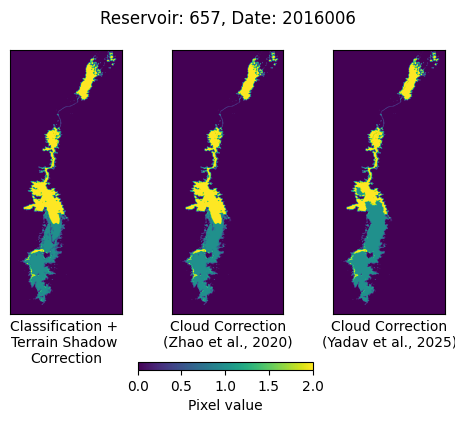

In [98]:
days = os.listdir(os.path.join(base_dir, 'results/hls_classified', str(grand_id)))
days.sort()

for d in days:
    dirpath = os.path.join(base_dir, 'results/hls_classified', str(grand_id), d)
    terrain = sparse.load_npz(os.path.join(dirpath, 'terrain.npz')).toarray()
    enh1 = sparse.load_npz(os.path.join(dirpath, 'enh1.npz')).toarray()
    enh2 = sparse.load_npz(os.path.join(dirpath, 'enh2.npz')).toarray()

    fig, ax = plt.subplots(1, 3, figsize=(5, 4))

    im0 = ax[0].imshow(terrain, cmap='viridis')
    ax[0].set_xlabel('Classification + \nTerrain Shadow \nCorrection')
    
    im1 = ax[1].imshow(enh1, cmap='viridis')
    ax[1].set_xlabel('Cloud Correction\n(Zhao et al., 2020)')
    
    im2 = ax[2].imshow(enh2, cmap='viridis')
    ax[2].set_xlabel('Cloud Correction\n(Yadav et al., 2025)')

    # Turn off axis ticks for all subplots
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    # Add a horizontal colorbar centered below all subplots
    cbar_ax = fig.add_axes([0.32, 0.08, 0.35, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im2, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Pixel value')

    plt.suptitle(f'Reservoir: {grand_id}, Date: {d}')
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit colorbar
    plt.show()
    break

# Contingency Check and getting .csv files for each reservoir

In [34]:
from collections import defaultdict
from tqdm import tqdm
from multiprocessing import Pool

In [35]:
# This piece of code makes sure that nothing went wrong during the processing of the reservoirs. 
# It checks that data from each year is avialable for all the reservoirs that were being processed.
# The variable incomplete_gid contains reservoirs for which something went wrong
new_gid = [int(f) for f in os.listdir(os.path.join(base_dir, 'results/hls_classified'))]
incomplete_gid = []
files = ['2016.zip','2017.zip','2018.zip','2019.zip','2020.zip','2021.zip','2022.zip','2023.zip']
for g in tqdm(new_gid):
    all_exist = all(Path(os.path.join(base_dir, f'results/hls_classified/{g}/{f}')).exists() for f in files)
    if not all_exist:
        incomplete_gid.append(g)

100%|██████████| 2/2 [00:00<00:00, 56.16it/s]


In [36]:
res_list = todo_res_list.copy()

In [37]:
res_gids = [x for x in res_list.keys() if x in incomplete_gid]
print(len(res_gids))

2


In [38]:
def process_gid(gid):
    """
    Processes a single GID: 
        1. Groups files by year.
        2. Creates a zip file for each year.
        3. Deletes the original files/directories.

    Args:
        gid: The GID to process.
    """
    directory_path = os.path.join(base_dir, f'results/hls_classified/{gid}')

    files_by_year = defaultdict(list)

    for file_name in os.listdir(directory_path):
        if file_name.isdigit() and len(file_name) == 7:
            year = file_name[:4]
            files_by_year[year].append(file_name)

    for year, files in files_by_year.items():
        zip_filename = f'{directory_path}/{year}.zip'

        with zipfile.ZipFile(zip_filename, 'w') as zipf:
            for file_name in files:
                file_path = os.path.join(directory_path, file_name)
                if os.path.isfile(file_path):
                    zipf.write(file_path, file_name)
                elif os.path.isdir(file_path):
                    for foldername, subfolders, filenames in os.walk(file_path):
                        for filename in filenames:
                            file_to_write = os.path.join(foldername, filename)
                            arcname = os.path.relpath(file_to_write, directory_path)
                            zipf.write(file_to_write, arcname)

        print(f"Created {zip_filename} with {len(files)} items.")

        for file_name in files:
            file_path = os.path.join(directory_path, file_name)
            try:
                if os.path.isfile(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except OSError as e:
                print(f"Error deleting {file_name}: {e}")

In [39]:
with Pool(processes=os.cpu_count()) as pool:  # Use all available CPU cores
    list(tqdm(pool.imap(process_gid, res_gids), total=len(res_gids)))

  0%|          | 0/2 [00:00<?, ?it/s]

Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/664/2022.zip with 141 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/657/2022.zip with 187 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/664/2017.zip with 71 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/657/2017.zip with 92 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/664/2021.zip with 110 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/657/2021.zip with 168 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/664/2020.zip with 102 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/664/2018.zip with 104 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/657/2020.zip with 159 items.
Created /scratch/user/anshulya/hls/github/hls/results/hls_classified/664/2019.zip with 102 items.
Created /scratch/user/

100%|██████████| 2/2 [01:39<00:00, 49.51s/it]


  0%|          | 0/7 [00:00<?, ?it/s]/tmp/job.2380196/ipykernel_2418459/867283765.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([date_dict])])
100%|██████████| 7/7 [00:11<00:00,  1.59s/it]


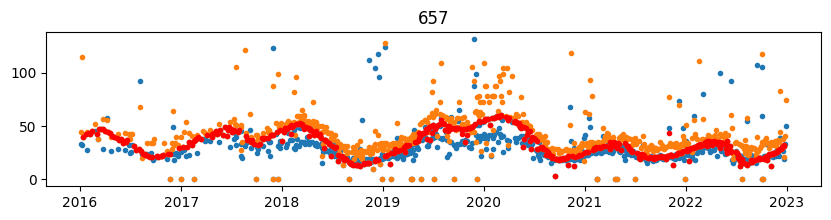

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/job.2380196/ipykernel_2418459/867283765.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([date_dict])])
100%|██████████| 7/7 [00:03<00:00,  2.32it/s]


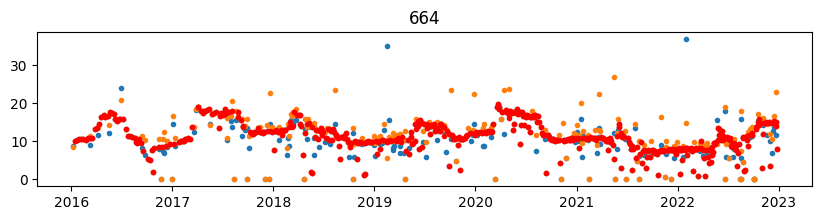

In [43]:
# Visualize the surface area time series data for each reservoir
for res in res_list.keys():

    columns = ['date', 'raw_area', 'enh1_area', 'enh2_area', 'cloud_cover', 'ice_cover']
    df = pd.DataFrame(columns=columns)
    
    for y in tqdm(range(2016,2023)):
        zip_file_path = os.path.join(base_dir, f'results/hls_classified/{res}/{y}.zip')

        # Open the zip file using 'zipfile.ZipFile'
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # List all files in the zip archive
            file_names = zip_ref.namelist()
            # print("Files in the zip archive:", y, len(file_names)/3)

            dates = list(dict.fromkeys([f.split('/')[0] for f in file_names])) # removing duplicate filenames

            for d in dates:
                try:
                    date_dict = {'date':d}
                    with zip_ref.open(f'{d}/terrain.npz') as file:
                        terr = np.load(io.BytesIO(file.read()))
                        data = terr['data']
                        indices = terr['indices']
                        indptr = terr['indptr']
                        shape = terr['shape']
                        sparse_matrix = csr_matrix((data, indices, indptr), shape=shape)
                        dense_matrix = sparse_matrix.toarray()
                        
                        ta = dense_matrix[(dense_matrix==1)].shape[0]*900/10**6
                        cca = dense_matrix[(dense_matrix==2)].shape[0]*900/10**6
                        ica = dense_matrix[(dense_matrix==3)].shape[0]*900/10**6
                        
                    with zip_ref.open(f'{d}/enh1.npz') as file:
                        terr = np.load(io.BytesIO(file.read()))
                        data = terr['data']
                        indices = terr['indices']
                        indptr = terr['indptr']
                        shape = terr['shape']
                        sparse_matrix = csr_matrix((data, indices, indptr), shape=shape)
                        dense_matrix = sparse_matrix.toarray()
                        
                        enh1 = dense_matrix[(dense_matrix==1)].shape[0]*900/10**6
    
                    with zip_ref.open(f'{d}/enh2.npz') as file:
                        terr = np.load(io.BytesIO(file.read()))
                        data = terr['data']
                        indices = terr['indices']
                        indptr = terr['indptr']
                        shape = terr['shape']
                        sparse_matrix = csr_matrix((data, indices, indptr), shape=shape)
                        dense_matrix = sparse_matrix.toarray()
                        
                        enh2 = dense_matrix[(dense_matrix==1)].shape[0]*900/10**6
                        
                    date_dict['raw_area'] = ta
                    date_dict['enh1_area'] = enh1
                    date_dict['enh2_area'] = enh2
                
                    if ta + cca == 0:
                        date_dict['cloud_cover'] = 0
                    else:
                        date_dict['cloud_cover'] = cca/(ta + cca)
                        
                    if ta + ica == 0:
                        date_dict['ice_cover'] = 0
                    else:
                        date_dict['ice_cover'] = ica/(ta + ica)
    
                    df = pd.concat([df, pd.DataFrame([date_dict])])
                except:
                    continue
    df['datetime'] = pd.to_datetime(df['date'], format='%Y%j')
    df_ = df[df['cloud_cover']<0.2]
    plt.figure(figsize=(10,2))
    plt.plot(df['datetime'],df['enh1_area'],'.')
    plt.plot(df['datetime'],df['enh2_area'],'.')
    plt.plot(df_['datetime'],df_['raw_area'],'r.')
    plt.title(res)
    plt.show()
    df.to_csv(os.path.join(base_dir, f'results/csv-files/{res}.csv'), index=False) # uncomment this line if you are satisfied with the time series plots to save the .csv files

# Outlier Detection and LOWESS Smoothing

In [41]:
df = pd.read_csv(os.path.join(base_dir, f'results/csv-files/{grand_id}.csv'))
df = df.sort_values(by='date')
df

,date,raw_area,enh1_area,enh2_area,cloud_cover,ice_cover,datetime
56,2016006,32.5404,33.3693,44.5518,0.609289,0.000000,2016-01-06
16,2016008,0.3141,32.3937,114.5142,0.997230,0.000000,2016-01-08
34,2016013,39.3003,39.3003,39.3003,0.091028,0.000000,2016-01-13
57,2016022,42.6348,42.6348,42.6348,0.075217,0.000000,2016-01-22
11,2016025,6.3810,27.2205,44.2944,0.945593,0.000000,2016-01-25
...,...,...,...,...,...,...,...
46,2016345,16.4646,24.0993,33.9786,0.819040,0.143860,2016-12-10
48,2016349,24.2388,24.5394,39.7098,0.812569,0.000000,2016-12-14
47,2016355,7.1865,21.9276,31.9041,0.931298,0.340573,2016-12-20
62,2016358,29.2734,29.2734,29.2734,0.142857,0.000000,2016-12-23


In [45]:
script_path = os.path.join(base_dir, "code/outlier_detection.py")

# Run the script
result = subprocess.run(
    ["python", script_path, "--gid", str(grand_id), "--base_dir", base_dir],
    capture_output=True,
    text=True
)

# Print output and errors
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

STDOUT:
 657 Elephant Butte Reservoir Elephant Butte Dike
[]
Outlier Detection starts here:
---------------------------------------------
##TEST###:  (980, 11) (980, 10)
Final surface area curve:
----------------------------------------
0.5224948875255624
Outlier Detection starts here:
---------------------------------------------
##TEST###:  (980, 11) (980, 10)
Final surface area curve:
----------------------------------------
0.36503067484662577

STDERR:
 /scratch/user/anshulya/hls/github/hls/code/outlier_detection.py:198: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = df_combined['lowess_area'].fillna(method='ffill').values  # Fill missing raw areas for continuity
/scratch/user/anshulya/hls/github/hls/code/outlier_detection.py:334: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = merged_df['lake_area'].f

In [48]:
merged_df = pd.read_csv(os.path.join(base_dir, 'results/final_files/657.csv'))

In [49]:
merged_df['datetime'] = pd.to_datetime(merged_df['datetime'])

## Comparison with in-situ data

In [50]:
in_situ_df = pd.read_csv(f'/scratch/user/anshulya/hls/data/auxiliary/in-situ_data.csv')
in_situ_df.keys()

Index(['Unnamed: 0', 'RES_NAME', 'date', 'stage_m', 'area_m2', 'depth_m',
       'datum', 'qflag'],
      dtype='object')

In [51]:
in_situ = in_situ_df[in_situ_df['RES_NAME'] == 'ELEPHANT BUTTE RESERVOIR']

In [52]:
in_situ['datetime'] = pd.to_datetime(in_situ['date'])

/tmp/job.2380196/ipykernel_2418459/3483353415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_situ['datetime'] = pd.to_datetime(in_situ['date'])


In [53]:
plot_df = pd.merge(merged_df, in_situ, on='datetime', how='inner')

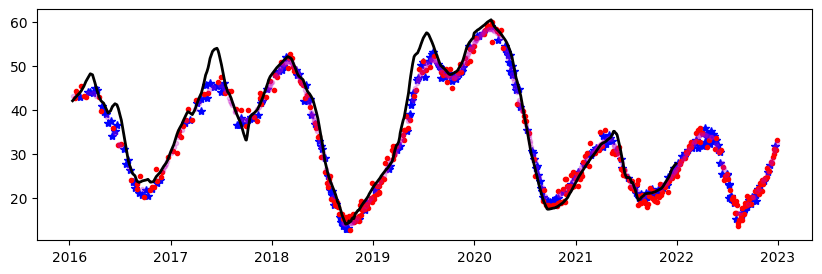

In [54]:
plt.figure(figsize=(10,3))

plt.plot(merged_df.loc[merged_df['flag']=='O','datetime'], merged_df.loc[merged_df['flag']=='O','lake_area'], 'b*')
plt.plot(merged_df.loc[merged_df['flag']=='E','datetime'], merged_df.loc[merged_df['flag']=='E','lake_area'], 'r.')
plt.plot(merged_df.loc[merged_df['flag']=='I','datetime'], merged_df.loc[merged_df['flag']=='I','lake_area'], 'm.', alpha=0.25)
for d in merged_df.loc[merged_df['flag']=='ICE','datetime']:
    plt.axvline(d, color='#89CFF0', alpha=0.5)
for d in merged_df.loc[merged_df['flag']=='P-ICE','datetime']:
    plt.axvline(d, color='#ADD8E6', alpha=0.5)
        
plt.plot(plot_df['datetime'], plot_df['area_m2']/10**6, linewidth=2, color='k')
plt.show()